## 2. Γραμμικός Προγραμματισμός

In [2]:
from scipy import optimize
import numpy as np

In [71]:
c = np.array([-5,-12])
A = np.array([
        [1, 3],    # x1 + 3x2 <= 5
        [1, -1],   # x1 - x2 <= 3
        [-7, 3], # -7x1 + 3x2 <= -1 (rearranged from 7x1 - 3x2 >= 1)
        [4, -9], # 4x1 - 9x2 <= 35
        [3, -7], # 3x1 - 7x2 <= 32
        [-2, 5], # -2x1 + 5x2 <= 26
    ])
b = np.array([5, 3, -1, 35, 32, 26])
x_bounds = (0, None)

d = np.linspace(0,16,300)
x1,x2 = np.meshgrid(d,d)
print(d)

[ 0.          0.05351171  0.10702341  0.16053512  0.21404682  0.26755853
  0.32107023  0.37458194  0.42809365  0.48160535  0.53511706  0.58862876
  0.64214047  0.69565217  0.74916388  0.80267559  0.85618729  0.909699
  0.9632107   1.01672241  1.07023411  1.12374582  1.17725753  1.23076923
  1.28428094  1.33779264  1.39130435  1.44481605  1.49832776  1.55183946
  1.60535117  1.65886288  1.71237458  1.76588629  1.81939799  1.8729097
  1.9264214   1.97993311  2.03344482  2.08695652  2.14046823  2.19397993
  2.24749164  2.30100334  2.35451505  2.40802676  2.46153846  2.51505017
  2.56856187  2.62207358  2.67558528  2.72909699  2.7826087   2.8361204
  2.88963211  2.94314381  2.99665552  3.05016722  3.10367893  3.15719064
  3.21070234  3.26421405  3.31772575  3.37123746  3.42474916  3.47826087
  3.53177258  3.58528428  3.63879599  3.69230769  3.7458194   3.7993311
  3.85284281  3.90635452  3.95986622  4.01337793  4.06688963  4.12040134
  4.17391304  4.22742475  4.28093645  4.33444816  4.3879

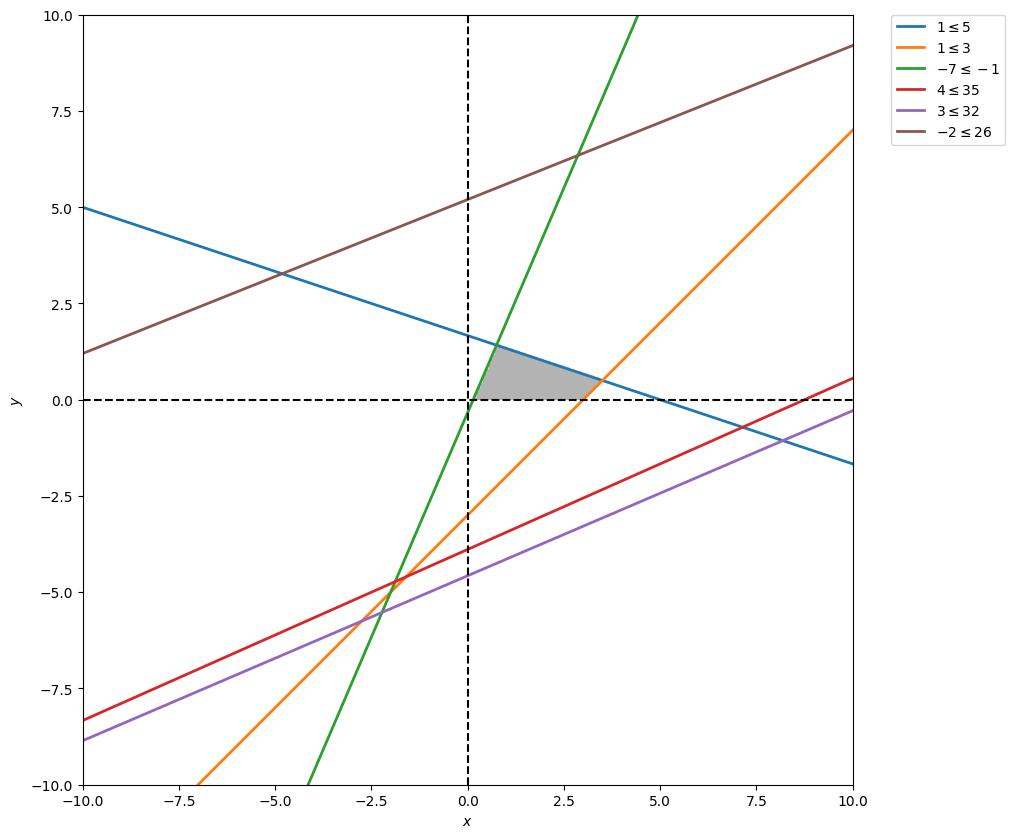

In [73]:
import numpy as np
np.float_ = np.float64
import matplotlib.pyplot as plt
def plot_feasible_region():
    d = np.linspace(0,16,300)
    x1,x2 = np.meshgrid(d,d)
    plt.figure(figsize=(10,10))
    feasible_region = np.logical_and.reduce([(A[i, 0] * x1 + A[i, 1] * x2 <= b[i]) for i in range(A.shape[0])])
    plt.imshow(feasible_region.astype(int) , 
                    extent=(x1.min(),x1.max(),x2.min(),x2.max()),origin="lower", cmap="Greys", alpha = 0.3);


    # plot the lines defining the constraints
    x1 = np.linspace(-1000, 1000, 2000)
    for i in range(A.shape[0]):
        x2 = (b[i] - A[i,0]*x1)/A[i,1]
        plt.plot(x1, x2, lw=2, label=r'$%s \leq %s$' % (A[i,0], b[i]))
    # y1 = (5 - x1)/3.0
    # y2 = x1 - 3
    # y3 = (-1 + 7*x1)/3.0
    # y4 = (4*x1 - 35)/9.0
    # y5 = (3*x1 - 32)/7.0
    # y6 = (26 + 2*x1)/5.0
    y0 = 0*x1
    # Make plot
    # plt.plot(0,np.linspace(0, 50, 2000))
    # plt.plot(x1, y1, label=r'$x1 + 3x2 \leq 5$')
    # plt.plot(x1, y2, label=r'$x1 - x2 \leq 3$')
    # plt.plot(x1, y3, label=r'$-7x1 + 3x2 \leq -1$')
    # plt.plot(x1, y4, label=r'$4x1 - 9x2 \leq 35$')
    # plt.plot(x1, y5, label=r'$3x1 - 7x2 \leq 32$')
    # plt.plot(x1, y6, label=r'$-2x1 + 5x2 \leq 26$')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    
plot_feasible_region()

#### Seidel's incremental algorithm in 2D

In [67]:
min_x = -np.inf
for i in range(len(A)):
    for j in range(i+1, len(A)):
        for k in range(j+1, len(A)):
            res = optimize.linprog(c, A_ub=[A[i], A[j], A[k]], b_ub=[b[i], b[j], b[k]], bounds=x_bounds)
            print(res.message)
            if res.success:
                print(res.x)
                print(res.fun)
                print(res.slack)

Optimization terminated successfully. (HiGHS Status 7: Optimal)
[3.5 0.5]
-23.5
[ 0.  0. 22.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[3.5 0.5]
-23.5
[ 0.   0.  25.5]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[3.5 0.5]
-23.5
[ 0.  0. 25.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[3.5 0.5]
-23.5
[ 0.   0.  30.5]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[5. 0.]
-25.0
[ 0. 34. 15.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[5. 0.]
-25.0
[ 0. 34. 17.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[5. 0.]
-25.0
[ 0. 34. 36.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[5. 0.]
-25.0
[ 0. 15. 17.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[5. 0.]
-25.0
[ 0. 15. 36.]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
[5. 0.]
-25.0
[ 0. 17. 36.]
The problem is unbounded. (HiGHS Status 10: model_status is Unboun